In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
base = '/mnt/local/scratch/pataki/AMR_pred/final_processed/'

disk_diff = pd.read_csv(f'{base}merged_top50.csv').fillna('NA')
disk_diff = disk_diff[disk_diff.measurement_units == 'mm']
disk_diff.pop('measurement_units');
disk_diff.pop('sample_alias');
disk_diff.pop('country');

y = disk_diff.pop('measurement')

disk_diff.head()

,CP009072.1_167295,CP009072.1_167306,CP009072.1_1589734,qnrS1,blaCTX-M-55,CP009072.1_3517597,CP009072.1_3517591,CP009072.1_1734215,CP009072.1_3517573,CP009072.1_113480,...,CP009072.1_4776473,CP009072.1_1176932,CP009072.1_113516,CP009072.1_3517509,CP009072.1_3517722,CP009072.1_3166388,CP009072.1_3517100,CP009072.1_3934862,CP009072.1_2536847,CP009072.1_548079
154,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
155,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
156,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,0,0,0,0,0
157,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
158,1,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [3]:
with open(f'{base}rf_4.pkl', 'rb') as f:
    rf_4 = pickle.load(f)
    
with open(f'{base}lr_4.pkl', 'rb') as f:
    lr_4 = pickle.load(f)
    
rf4_pred = rf_4.predict(disk_diff[disk_diff.columns.values[:4]])
lr4_pred = lr_4.predict(disk_diff[disk_diff.columns.values[:4]])

/home/pataki/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


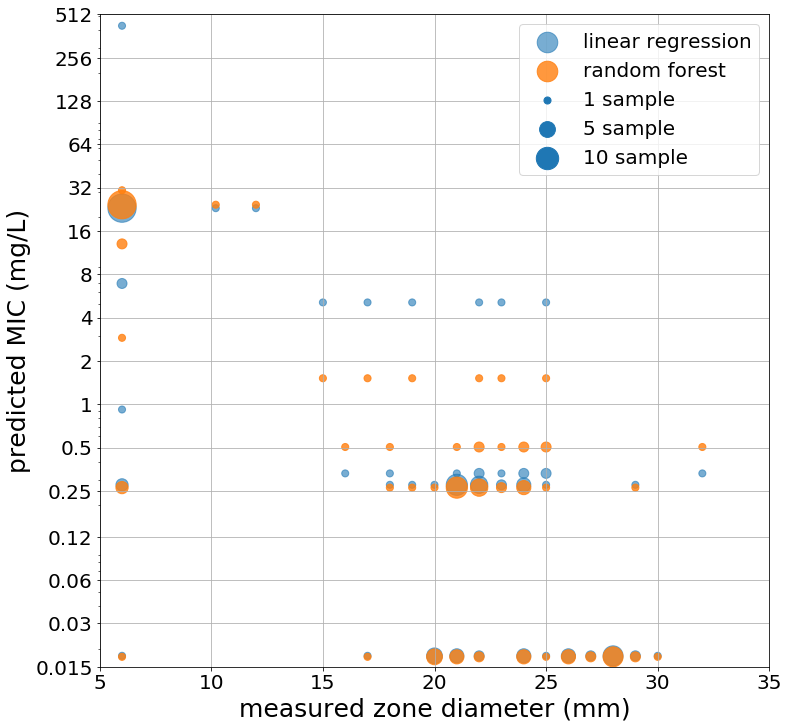

In [9]:
mult = 50
lrpredDF = pd.DataFrame({'pred': 2**(lr4_pred), 'truth' : y})
lrplotDF = lrpredDF.reset_index().groupby(['pred', 'truth']).count().reset_index()

rfpredDF = pd.DataFrame({'pred': 2**(rf4_pred), 'truth' : y})
rfplotDF = rfpredDF.reset_index().groupby(['pred', 'truth']).count().reset_index()

plt.rcParams['figure.figsize'] = (12, 12)
plt.scatter(lrplotDF.truth.tolist(), lrplotDF.pred.tolist(), 
            s=np.array(lrplotDF['index'].tolist())*mult, label='linear regression', alpha=0.6)
plt.scatter(rfplotDF.truth.tolist(), rfplotDF.pred.tolist(), 
            s=np.array(rfplotDF['index'].tolist())*mult, label='random forest', alpha=0.8)


plt.scatter(-1, -1, s=1*mult, label='1 sample', c='C0')
plt.scatter(-1, -1, s=5*mult, label='5 sample', c='C0')
plt.scatter(-1, -1, s=10*mult, label='10 sample', c='C0')



plt.xlim(5, 35)
plt.ylim(0.015, 280)


plt.xlabel('measured zone diameter (mm)', fontsize=25)
plt.ylabel('predicted MIC (mg/L)', fontsize=25)
plt.legend(fontsize=20)
#plt.xscale('log')
plt.yscale('log')

xtck = [5, 10, 15, 20, 25, 30, 35]
ytck = [0.015, 0.03, 0.06, 0.12, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

plt.xticks(xtck, [str(i) for i in xtck], fontsize=20)
plt.yticks(ytck, [str(i) for i in ytck], fontsize=20)

plt.grid()
#plt.title('MIC (mg/L) prediction based on 4 markers', fontsize=25)
plt.savefig('../figs/cipro_zone_scatter.pdf')
#plt.savefig('cipro_MIC_scatter.png', dpi=1000)
plt.show()

In [5]:
VCFfiles = !ls /mnt/local/scratch/pataki/AMR_pred/VCFs/*

vcf_counts = []
for i in VCFfiles:
    cnt = !wc -l $i
    vcf_counts.append(int(cnt[0].split()[0]))

In [6]:
FASTQfiles = !ls /mnt/local/scratch/pataki/AMR_pred/FASTQs/*_1.fastq.gz

fastq_counts = []
for i in FASTQfiles:
    cnt = !zcat $i | wc -l 
    fastq_counts.append(int(cnt[0].split()[0])/2) # every 4th is a read, but we have paired-end seq

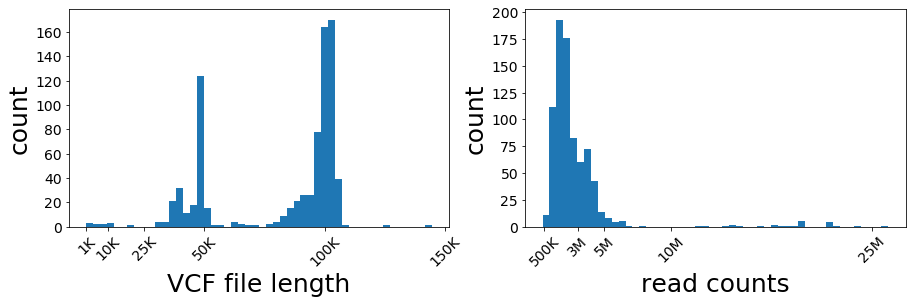

In [10]:
plt.rcParams['figure.figsize'] = (15, 4)
plt.subplot(121)
plt.hist(vcf_counts, bins=50)
plt.xlabel('VCF file length', fontsize=25)
plt.xticks([1e3, 1e4, 2.5e4, 5e4, 1e5, 1.5e5], 
           ['1K', '10K', '25K', '50K', '100K', '150K'], rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('count', fontsize=25)

plt.subplot(122)
plt.hist(fastq_counts, bins=50)
plt.xlabel('read counts', fontsize=25)
plt.xticks([5e5, 3e6, 5e6, 10e6, 25e6], ['500K', '3M', '5M', '10M', '25M'], fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('count', fontsize=25)

plt.savefig('../figs/quality.pdf', bbox_inches='tight')
plt.show()

In [11]:
data = pd.read_csv(f'{base}merged_top50.csv')
data = data[data.measurement_units == 'mg/L'][['country', 'measurement', 'sample_alias']].fillna('NA')
data = data.groupby(['country', 'measurement']).count().reset_index()
data_pivot = data.pivot_table(index='country', columns='measurement', values='sample_alias', 
                              margins = True, aggfunc=np.sum)
data_pivot = data_pivot.T.fillna(0).astype(int)


with open('../tables/samples.txt', 'wt') as f:
    f.write(data_pivot.to_latex())